In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timezone, datetime
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from yellowbrick.regressor import PredictionError
import pytz
from functools import reduce


plt.style.use('fivethirtyeight')
%matplotlib inline

pac = pytz.timezone('America/Los_Angeles')
utc = pytz.timezone('UTC')


In [33]:
fre = './Data/Bike_Counts/Fremont_Bridge.csv'
fremont = pd.read_csv(fre,parse_dates = [0],index_col='Date')

fremont.rename(columns = {'Fremont Bridge East Sidewalk' : 'EastSide',
                         'Fremont Bridge West Sidewalk':'WestSide',
                         'Date':'Date_Join'} , inplace= True)


fremont = fremont.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')
fremont_d = fremont.resample('D').sum()
fremont_d.index.names = ['Date_Join']
#fremont_d.head(10)

In [34]:
path = "./Data/Daily_Summaries/Daily_Summaries_Merged.csv"
d = ","
wx = pd.read_csv(path,delimiter=d)
wx.DATE = pd.to_datetime(wx.DATE)
wx.rename(columns={'DATE':'Date_Join'},inplace = True)
#wx.drop(['LATITUDE','LONGITUDE'],axis = 1,inplace=True);
#wx.head()

In [35]:
wx.loc[wx['STATION'] == 'USW00024233', 'NAME'] = 'SeaTac'
wx.loc[wx['STATION'] == 'USW00024234', 'NAME'] = 'Boeing_Field'
wx.loc[wx['STATION'] == 'US1WAKG0079', 'NAME'] = 'Magnolia'
wx.loc[wx['STATION'] == 'US1WAKG0145', 'NAME'] = 'Phinney'
wx.loc[wx['STATION'] == 'US1WAKG0200', 'NAME'] = 'Georgetown'
wx.loc[wx['STATION'] == 'US1WAKG0199', 'NAME'] = 'GreenWood'
wx.loc[wx['STATION'] == 'US1WAKG0225', 'NAME'] = 'Cap_Hill'
wx.loc[wx['STATION'] == 'US1WAKG0239', 'NAME'] = 'Woodland_Park'


In [36]:
wx_d = wx.groupby(by = 'Date_Join')[['PRCP','TMAX','TMIN']].mean()
wx_d = wx_d.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')
#wx_d.head()

In [38]:
data = fremont_d.merge(wx_d, how = 'inner',left_on = 'Date_Join',right_on = 'Date_Join')
data.head()

,EastSide,WestSide,PRCP,TMAX,TMIN
Date_Join,,,,,
2012-10-03 00:00:00-07:00,1760.0,1761.0,0.0,66.0,45.5
2012-10-04 00:00:00-07:00,1708.0,1767.0,0.0,65.5,47.0
2012-10-05 00:00:00-07:00,1558.0,1590.0,0.0,70.5,47.0
2012-10-06 00:00:00-07:00,1080.0,926.0,0.0,73.0,43.5
2012-10-07 00:00:00-07:00,1191.0,951.0,0.0,73.5,45.0


In [40]:
features = ['PRCP','TMAX','TMIN']
X = data[features]
y = data['EastSide']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state= 23)

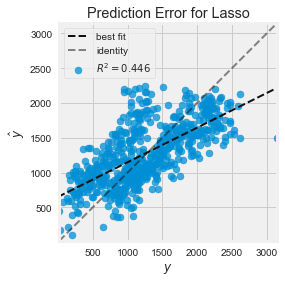

In [41]:
#fit the model
lasso = Lasso()

visualizer = PredictionError(lasso)
linreg = LinearRegression(lasso)

linreg.fit(X_train, y_train)
visualizer.fit(X_train, y_train)

y_pred = linreg.predict(X_test)



visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data


In [42]:

for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, linreg.coef_[idx]))

#list(zip(features, linreg.coef_))
print("R-squared = ", linreg.score(X_test, y_test))  

print("RMSE = ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

The coefficient for PRCP is -614.5493825208117
The coefficient for TMAX is 34.28100855445099
The coefficient for TMIN is -8.768459438659118
R-squared =  0.4453176961625634
RMSE =  444.28122328637346


In [43]:
#set index
y_pred= pd.DataFrame(y_pred,index=X_test.index)
y_pred.rename(columns={y_pred.columns[0]:'Predicted_East'}, inplace=True)

y_test= pd.DataFrame(y_test,index=X_test.index)
y_test.rename(columns={y_test.columns[0]:'Actual_East'}, inplace=True)

In [47]:
dfs = (X_test,y_test,y_pred)

results = reduce(lambda left,right: pd.merge(left,right,on = 'Date_Join'),dfs)
results['DIF'] = abs(results['Actual_East'] - results['Predicted_East'])

#X_test.head()
#y_pred
#y_test
results.sort_values(by = 'DIF',ascending= False).head()

,PRCP,TMAX,TMIN,Actual_East,Predicted_East,DIF
Date_Join,,,,,,
2014-05-16 00:00:00-07:00,0.0,68.5,54.0,3143.0,1495.097272,1647.902728
2016-08-20 00:00:00-07:00,0.0,91.0,62.0,942.0,2196.272289,1254.272289
2016-08-13 00:00:00-07:00,0.0,90.5,64.5,947.0,2157.210636,1210.210636
2015-07-05 00:00:00-07:00,0.0,91.0,64.5,1008.0,2174.351140,1166.351140
2013-05-01 00:00:00-07:00,0.0,64.5,38.0,2615.0,1498.268589,1116.731411
